# Import

In [23]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [24]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.95

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 170

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 50

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [25]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [26]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  47500
- Length of Valid Set :  2500
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [27]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
valid.transforms = ToTensor() 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [30]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [31]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [32]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [33]:
scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=10, factor=0.1, cooldown=50)

## (5) Define AMP scaler

In [34]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [35]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [36]:
optimizer.param_groups[0]["lr"]

0.1

In [37]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [38]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/170] :


1 Train: 100%|███████| 372/372 [01:34<00:00,  3.95it/s]

Train Loss: 2.4456 | Train Acc: 10.40%


Valid Loss: 2.2895 | Valid Acc: 10.28%
Test  Loss: 2.2637 | Test Acc: 12.94%
updated best eval loss : 2.2894911646842955
--------------------------------------------------
[Epoch 2/170] :


2 Train: 100%|███████| 372/372 [01:21<00:00,  4.57it/s]


Train Loss: 2.1928 | Train Acc: 16.68%
Valid Loss: 2.0918 | Valid Acc: 24.56%
Test  Loss: 2.1129 | Test Acc: 20.60%
updated best eval loss : 2.0917852401733397
--------------------------------------------------
[Epoch 3/170] :


3 Train: 100%|███████| 372/372 [01:21<00:00,  4.59it/s]


Train Loss: 1.8797 | Train Acc: 30.15%
Valid Loss: 1.7872 | Valid Acc: 34.80%
Test  Loss: 2.0979 | Test Acc: 25.94%
updated best eval loss : 1.78724085688591
--------------------------------------------------
[Epoch 4/170] :


4 Train: 100%|███████| 372/372 [01:21<00:00,  4.57it/s]


Train Loss: 1.5824 | Train Acc: 42.67%
Valid Loss: 1.6347 | Valid Acc: 42.80%
Test  Loss: 1.9098 | Test Acc: 33.25%
updated best eval loss : 1.6347011744976043
--------------------------------------------------
[Epoch 5/170] :


5 Train: 100%|███████| 372/372 [01:21<00:00,  4.57it/s]


Train Loss: 1.3653 | Train Acc: 50.67%
Valid Loss: 1.3452 | Valid Acc: 52.08%
Test  Loss: 1.2723 | Test Acc: 55.18%
updated best eval loss : 1.345199716091156
--------------------------------------------------
[Epoch 6/170] :


6 Train: 100%|███████| 372/372 [01:20<00:00,  4.62it/s]


Train Loss: 1.1885 | Train Acc: 57.41%
Valid Loss: 1.3742 | Valid Acc: 53.00%
Test  Loss: 1.1632 | Test Acc: 58.57%
--------------------------------------------------
[Epoch 7/170] :


7 Train: 100%|███████| 372/372 [01:21<00:00,  4.57it/s]


Train Loss: 1.0547 | Train Acc: 62.72%
Valid Loss: 1.2010 | Valid Acc: 59.04%
Test  Loss: 2.8175 | Test Acc: 34.02%
updated best eval loss : 1.2010330379009246
--------------------------------------------------
[Epoch 8/170] :


8 Train: 100%|███████| 372/372 [01:22<00:00,  4.53it/s]


Train Loss: 0.9595 | Train Acc: 66.51%
Valid Loss: 1.0406 | Valid Acc: 63.16%
Test  Loss: 0.9785 | Test Acc: 67.50%
updated best eval loss : 1.0405680119991303
--------------------------------------------------
[Epoch 9/170] :


9 Train: 100%|███████| 372/372 [01:22<00:00,  4.53it/s]


Train Loss: 0.9044 | Train Acc: 68.43%
Valid Loss: 1.1979 | Valid Acc: 61.36%
Test  Loss: 1.5272 | Test Acc: 54.03%
--------------------------------------------------
[Epoch 10/170] :


10 Train: 100%|██████| 372/372 [01:22<00:00,  4.53it/s]


Train Loss: 0.8622 | Train Acc: 69.77%
Valid Loss: 0.9095 | Valid Acc: 67.40%
Test  Loss: 0.8288 | Test Acc: 71.50%
updated best eval loss : 0.909481155872345
--------------------------------------------------
[Epoch 11/170] :


11 Train: 100%|██████| 372/372 [01:22<00:00,  4.53it/s]


Train Loss: 0.7987 | Train Acc: 72.24%
Valid Loss: 0.9285 | Valid Acc: 67.52%
Test  Loss: 1.0072 | Test Acc: 67.03%
--------------------------------------------------
[Epoch 12/170] :


12 Train: 100%|██████| 372/372 [01:21<00:00,  4.58it/s]


Train Loss: 0.7777 | Train Acc: 72.78%
Valid Loss: 0.8747 | Valid Acc: 69.92%
Test  Loss: 0.7422 | Test Acc: 73.92%
updated best eval loss : 0.8746830433607101
--------------------------------------------------
[Epoch 13/170] :


13 Train: 100%|██████| 372/372 [01:21<00:00,  4.57it/s]


Train Loss: 0.7512 | Train Acc: 73.78%
Valid Loss: 1.0931 | Valid Acc: 66.16%
Test  Loss: 1.6363 | Test Acc: 56.79%
--------------------------------------------------
[Epoch 14/170] :


14 Train: 100%|██████| 372/372 [01:21<00:00,  4.56it/s]


Train Loss: 0.7252 | Train Acc: 74.90%
Valid Loss: 0.8424 | Valid Acc: 71.16%
Test  Loss: 1.1618 | Test Acc: 63.70%
updated best eval loss : 0.8424089193344116
--------------------------------------------------
[Epoch 15/170] :


15 Train: 100%|██████| 372/372 [01:21<00:00,  4.54it/s]


Train Loss: 0.7008 | Train Acc: 75.83%
Valid Loss: 1.0431 | Valid Acc: 64.32%
Test  Loss: 1.2142 | Test Acc: 61.00%
--------------------------------------------------
[Epoch 16/170] :


16 Train: 100%|██████| 372/372 [01:21<00:00,  4.55it/s]


Train Loss: 0.6979 | Train Acc: 75.70%
Valid Loss: 0.8127 | Valid Acc: 71.04%
Test  Loss: 0.6338 | Test Acc: 78.35%
updated best eval loss : 0.8126820981502533
--------------------------------------------------
[Epoch 17/170] :


17 Train: 100%|██████| 372/372 [01:20<00:00,  4.61it/s]


Train Loss: 0.6649 | Train Acc: 76.93%
Valid Loss: 0.8370 | Valid Acc: 71.04%
Test  Loss: 0.7385 | Test Acc: 75.59%
--------------------------------------------------
[Epoch 18/170] :


18 Train: 100%|██████| 372/372 [01:21<00:00,  4.59it/s]


Train Loss: 0.6535 | Train Acc: 77.31%
Valid Loss: 0.8197 | Valid Acc: 71.76%
Test  Loss: 0.8611 | Test Acc: 71.84%
--------------------------------------------------
[Epoch 19/170] :


19 Train: 100%|██████| 372/372 [01:20<00:00,  4.61it/s]


Train Loss: 0.6427 | Train Acc: 77.51%
Valid Loss: 0.7390 | Valid Acc: 73.96%
Test  Loss: 1.0493 | Test Acc: 67.29%
updated best eval loss : 0.7389577001333236
--------------------------------------------------
[Epoch 20/170] :


20 Train: 100%|██████| 372/372 [01:20<00:00,  4.59it/s]


Train Loss: 0.6259 | Train Acc: 78.43%
Valid Loss: 0.7673 | Valid Acc: 72.96%
Test  Loss: 0.8306 | Test Acc: 73.26%
--------------------------------------------------
[Epoch 21/170] :


21 Train: 100%|██████| 372/372 [01:22<00:00,  4.52it/s]


Train Loss: 0.6228 | Train Acc: 78.45%
Valid Loss: 0.8429 | Valid Acc: 71.56%
Test  Loss: 0.6976 | Test Acc: 76.27%
--------------------------------------------------
[Epoch 22/170] :


22 Train: 100%|██████| 372/372 [01:20<00:00,  4.64it/s]


Train Loss: 0.6095 | Train Acc: 78.84%
Valid Loss: 0.7301 | Valid Acc: 75.60%
Test  Loss: 0.8482 | Test Acc: 72.53%
updated best eval loss : 0.7301307991147041
--------------------------------------------------
[Epoch 23/170] :


23 Train: 100%|██████| 372/372 [01:21<00:00,  4.56it/s]


Train Loss: 0.5951 | Train Acc: 79.39%
Valid Loss: 0.7897 | Valid Acc: 73.00%
Test  Loss: 0.8863 | Test Acc: 70.75%
--------------------------------------------------
[Epoch 24/170] :


24 Train: 100%|██████| 372/372 [01:21<00:00,  4.57it/s]


Train Loss: 0.5834 | Train Acc: 79.87%
Valid Loss: 0.7256 | Valid Acc: 76.24%
Test  Loss: 0.7348 | Test Acc: 76.32%
updated best eval loss : 0.7255519986152649
--------------------------------------------------
[Epoch 25/170] :


25 Train: 100%|██████| 372/372 [01:21<00:00,  4.55it/s]


Train Loss: 0.5797 | Train Acc: 79.96%
Valid Loss: 0.8386 | Valid Acc: 71.80%
Test  Loss: 0.6695 | Test Acc: 77.81%
--------------------------------------------------
[Epoch 26/170] :


26 Train: 100%|██████| 372/372 [01:21<00:00,  4.54it/s]


Train Loss: 0.5794 | Train Acc: 79.91%
Valid Loss: 0.7360 | Valid Acc: 74.56%
Test  Loss: 0.6368 | Test Acc: 77.83%
--------------------------------------------------
[Epoch 27/170] :


27 Train: 100%|██████| 372/372 [01:20<00:00,  4.60it/s]


Train Loss: 0.5707 | Train Acc: 80.13%
Valid Loss: 0.7377 | Valid Acc: 73.84%
Test  Loss: 0.8485 | Test Acc: 71.91%
--------------------------------------------------
[Epoch 28/170] :


28 Train: 100%|██████| 372/372 [01:21<00:00,  4.55it/s]


Train Loss: 0.5608 | Train Acc: 80.56%
Valid Loss: 0.6788 | Valid Acc: 76.12%
Test  Loss: 0.6876 | Test Acc: 76.31%
updated best eval loss : 0.6788116931915283
--------------------------------------------------
[Epoch 29/170] :


29 Train: 100%|██████| 372/372 [01:22<00:00,  4.49it/s]


Train Loss: 0.5472 | Train Acc: 80.96%
Valid Loss: 0.6661 | Valid Acc: 76.60%
Test  Loss: 0.7356 | Test Acc: 76.15%
updated best eval loss : 0.6660529568791389
--------------------------------------------------
[Epoch 30/170] :


30 Train: 100%|██████| 372/372 [01:21<00:00,  4.59it/s]


Train Loss: 0.5532 | Train Acc: 80.99%
Valid Loss: 0.7038 | Valid Acc: 76.56%
Test  Loss: 0.7155 | Test Acc: 76.66%
--------------------------------------------------
[Epoch 31/170] :


31 Train: 100%|██████| 372/372 [01:21<00:00,  4.56it/s]


Train Loss: 0.5358 | Train Acc: 81.43%
Valid Loss: 0.6890 | Valid Acc: 76.00%
Test  Loss: 0.6132 | Test Acc: 78.86%
--------------------------------------------------
[Epoch 32/170] :


32 Train: 100%|██████| 372/372 [01:22<00:00,  4.50it/s]


Train Loss: 0.5363 | Train Acc: 81.31%
Valid Loss: 0.6848 | Valid Acc: 77.48%
Test  Loss: 0.7268 | Test Acc: 76.50%
--------------------------------------------------
[Epoch 33/170] :


33 Train: 100%|██████| 372/372 [01:20<00:00,  4.62it/s]


Train Loss: 0.5257 | Train Acc: 81.78%
Valid Loss: 0.7140 | Valid Acc: 76.16%
Test  Loss: 0.7610 | Test Acc: 75.08%
--------------------------------------------------
[Epoch 34/170] :


34 Train: 100%|██████| 372/372 [01:21<00:00,  4.56it/s]


Train Loss: 0.5239 | Train Acc: 81.75%
Valid Loss: 0.7195 | Valid Acc: 76.04%
Test  Loss: 0.6879 | Test Acc: 77.66%
--------------------------------------------------
[Epoch 35/170] :


35 Train: 100%|██████| 372/372 [01:21<00:00,  4.58it/s]


Train Loss: 0.5208 | Train Acc: 81.87%
Valid Loss: 0.6281 | Valid Acc: 78.24%
Test  Loss: 0.6647 | Test Acc: 78.29%
updated best eval loss : 0.6281392127275467
--------------------------------------------------
[Epoch 36/170] :


36 Train: 100%|██████| 372/372 [01:21<00:00,  4.58it/s]


Train Loss: 0.5150 | Train Acc: 82.09%
Valid Loss: 0.7269 | Valid Acc: 74.96%
Test  Loss: 0.7958 | Test Acc: 73.09%
--------------------------------------------------
[Epoch 37/170] :


37 Train: 100%|██████| 372/372 [01:21<00:00,  4.55it/s]


Train Loss: 0.5143 | Train Acc: 82.23%
Valid Loss: 0.6417 | Valid Acc: 77.96%
Test  Loss: 0.6799 | Test Acc: 77.96%
--------------------------------------------------
[Epoch 38/170] :


38 Train: 100%|██████| 372/372 [01:21<00:00,  4.58it/s]


Train Loss: 0.5074 | Train Acc: 82.49%
Valid Loss: 0.6811 | Valid Acc: 76.04%
Test  Loss: 0.5852 | Test Acc: 79.98%
--------------------------------------------------
[Epoch 39/170] :


39 Train: 100%|██████| 372/372 [01:21<00:00,  4.57it/s]


Train Loss: 0.5044 | Train Acc: 82.53%
Valid Loss: 0.6669 | Valid Acc: 77.48%
Test  Loss: 0.4697 | Test Acc: 84.00%
--------------------------------------------------
[Epoch 40/170] :


40 Train: 100%|██████| 372/372 [01:20<00:00,  4.62it/s]


Train Loss: 0.4969 | Train Acc: 82.89%
Valid Loss: 0.7209 | Valid Acc: 75.60%
Test  Loss: 0.4995 | Test Acc: 83.04%
--------------------------------------------------
[Epoch 41/170] :


41 Train: 100%|██████| 372/372 [01:20<00:00,  4.64it/s]


Train Loss: 0.4933 | Train Acc: 82.95%
Valid Loss: 0.6888 | Valid Acc: 77.00%
Test  Loss: 0.8010 | Test Acc: 73.64%
--------------------------------------------------
[Epoch 42/170] :


42 Train: 100%|██████| 372/372 [01:11<00:00,  5.19it/s]


Train Loss: 0.4954 | Train Acc: 82.67%
Valid Loss: 0.6480 | Valid Acc: 77.64%
Test  Loss: 0.5673 | Test Acc: 80.76%
--------------------------------------------------
[Epoch 43/170] :


43 Train: 100%|██████| 372/372 [00:50<00:00,  7.37it/s]


Train Loss: 0.4903 | Train Acc: 83.13%
Valid Loss: 0.6342 | Valid Acc: 78.08%
Test  Loss: 0.6011 | Test Acc: 80.15%
--------------------------------------------------
[Epoch 44/170] :


44 Train: 100%|██████| 372/372 [00:45<00:00,  8.19it/s]


Train Loss: 0.4821 | Train Acc: 83.23%
Valid Loss: 0.5821 | Valid Acc: 79.24%
Test  Loss: 0.5779 | Test Acc: 80.48%
updated best eval loss : 0.5820921286940575
--------------------------------------------------
[Epoch 45/170] :


45 Train: 100%|██████| 372/372 [00:41<00:00,  8.95it/s]


Train Loss: 0.4802 | Train Acc: 83.39%
Valid Loss: 0.6829 | Valid Acc: 77.36%
Test  Loss: 0.5893 | Test Acc: 80.16%
--------------------------------------------------
[Epoch 46/170] :


46 Train: 100%|██████| 372/372 [00:41<00:00,  8.92it/s]


Train Loss: 0.4819 | Train Acc: 83.27%
Valid Loss: 0.6233 | Valid Acc: 78.08%
Test  Loss: 0.5697 | Test Acc: 80.70%
--------------------------------------------------
[Epoch 47/170] :


47 Train: 100%|██████| 372/372 [00:41<00:00,  8.97it/s]


Train Loss: 0.4788 | Train Acc: 83.31%
Valid Loss: 0.6496 | Valid Acc: 77.96%
Test  Loss: 0.6660 | Test Acc: 78.64%
--------------------------------------------------
[Epoch 48/170] :


48 Train: 100%|██████| 372/372 [00:42<00:00,  8.82it/s]


Train Loss: 0.4852 | Train Acc: 83.29%
Valid Loss: 0.6668 | Valid Acc: 76.92%
Test  Loss: 0.6443 | Test Acc: 78.93%
--------------------------------------------------
[Epoch 49/170] :


49 Train: 100%|██████| 372/372 [00:41<00:00,  8.96it/s]


Train Loss: 0.4743 | Train Acc: 83.47%
Valid Loss: 0.6719 | Valid Acc: 76.68%
Test  Loss: 0.8270 | Test Acc: 73.76%
--------------------------------------------------
[Epoch 50/170] :


50 Train: 100%|██████| 372/372 [00:42<00:00,  8.84it/s]


Train Loss: 0.4712 | Train Acc: 83.69%
Valid Loss: 0.6047 | Valid Acc: 78.60%
Test  Loss: 0.4811 | Test Acc: 84.06%
--------------------------------------------------
[Epoch 51/170] :


51 Train: 100%|██████| 372/372 [00:42<00:00,  8.80it/s]


Train Loss: 0.4705 | Train Acc: 83.68%
Valid Loss: 0.7366 | Valid Acc: 74.72%
Test  Loss: 0.8987 | Test Acc: 71.52%
--------------------------------------------------
[Epoch 52/170] :


52 Train: 100%|██████| 372/372 [00:42<00:00,  8.84it/s]


Train Loss: 0.4666 | Train Acc: 83.91%
Valid Loss: 0.6010 | Valid Acc: 78.48%
Test  Loss: 0.6238 | Test Acc: 78.71%
--------------------------------------------------
[Epoch 53/170] :


53 Train: 100%|██████| 372/372 [00:41<00:00,  8.95it/s]


Train Loss: 0.4672 | Train Acc: 83.70%
Valid Loss: 0.7002 | Valid Acc: 76.44%
Test  Loss: 0.5871 | Test Acc: 80.73%
--------------------------------------------------
[Epoch 54/170] :


54 Train: 100%|██████| 372/372 [00:41<00:00,  9.03it/s]


Train Loss: 0.4661 | Train Acc: 83.92%
Valid Loss: 0.5919 | Valid Acc: 78.96%
Test  Loss: 0.5822 | Test Acc: 80.64%
--------------------------------------------------
[Epoch 55/170] :


55 Train: 100%|██████| 372/372 [00:31<00:00, 11.83it/s]


Train Loss: 0.4592 | Train Acc: 84.06%
Valid Loss: 0.7267 | Valid Acc: 76.88%
Test  Loss: 0.7476 | Test Acc: 76.36%
--------------------------------------------------
[Epoch 56/170] :


56 Train: 100%|██████| 372/372 [00:31<00:00, 11.90it/s]


Train Loss: 0.3710 | Train Acc: 87.10%
Valid Loss: 0.4469 | Valid Acc: 84.40%
Test  Loss: 0.4246 | Test Acc: 85.42%
updated best eval loss : 0.44687939435243607
--------------------------------------------------
[Epoch 57/170] :


57 Train: 100%|██████| 372/372 [00:30<00:00, 12.08it/s]


Train Loss: 0.3344 | Train Acc: 88.40%
Valid Loss: 0.4358 | Valid Acc: 84.52%
Test  Loss: 0.4207 | Test Acc: 85.65%
updated best eval loss : 0.43580309897661207
--------------------------------------------------
[Epoch 58/170] :


58 Train: 100%|██████| 372/372 [00:31<00:00, 11.72it/s]


Train Loss: 0.3267 | Train Acc: 88.57%
Valid Loss: 0.4101 | Valid Acc: 85.52%
Test  Loss: 0.4478 | Test Acc: 84.93%
updated best eval loss : 0.4101248264312744
--------------------------------------------------
[Epoch 59/170] :


59 Train: 100%|██████| 372/372 [00:31<00:00, 11.67it/s]


Train Loss: 0.3174 | Train Acc: 89.04%
Valid Loss: 0.4256 | Valid Acc: 84.96%
Test  Loss: 0.4143 | Test Acc: 86.26%
--------------------------------------------------
[Epoch 60/170] :


60 Train: 100%|██████| 372/372 [00:31<00:00, 11.85it/s]


Train Loss: 0.3102 | Train Acc: 89.04%
Valid Loss: 0.4184 | Valid Acc: 85.48%
Test  Loss: 0.4009 | Test Acc: 86.79%
--------------------------------------------------
[Epoch 61/170] :


61 Train: 100%|██████| 372/372 [00:31<00:00, 11.71it/s]


Train Loss: 0.3086 | Train Acc: 89.23%
Valid Loss: 0.4277 | Valid Acc: 84.16%
Test  Loss: 0.3950 | Test Acc: 86.58%
--------------------------------------------------
[Epoch 62/170] :


62 Train: 100%|██████| 372/372 [00:31<00:00, 11.91it/s]


Train Loss: 0.2979 | Train Acc: 89.48%
Valid Loss: 0.4016 | Valid Acc: 85.96%
Test  Loss: 0.3772 | Test Acc: 87.24%
updated best eval loss : 0.40159533768892286
--------------------------------------------------
[Epoch 63/170] :


63 Train: 100%|██████| 372/372 [00:31<00:00, 11.81it/s]


Train Loss: 0.2984 | Train Acc: 89.68%
Valid Loss: 0.4178 | Valid Acc: 85.44%
Test  Loss: 0.3998 | Test Acc: 86.85%
--------------------------------------------------
[Epoch 64/170] :


64 Train: 100%|██████| 372/372 [00:31<00:00, 11.95it/s]


Train Loss: 0.2947 | Train Acc: 89.60%
Valid Loss: 0.4199 | Valid Acc: 85.88%
Test  Loss: 0.3873 | Test Acc: 87.27%
--------------------------------------------------
[Epoch 65/170] :


65 Train: 100%|██████| 372/372 [00:31<00:00, 11.79it/s]


Train Loss: 0.2908 | Train Acc: 89.78%
Valid Loss: 0.3947 | Valid Acc: 86.48%
Test  Loss: 0.3687 | Test Acc: 87.64%
updated best eval loss : 0.39471378847956656
--------------------------------------------------
[Epoch 66/170] :


66 Train: 100%|██████| 372/372 [00:31<00:00, 11.85it/s]


Train Loss: 0.2954 | Train Acc: 89.69%
Valid Loss: 0.4019 | Valid Acc: 86.24%
Test  Loss: 0.3786 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 67/170] :


67 Train: 100%|██████| 372/372 [00:30<00:00, 12.01it/s]


Train Loss: 0.2860 | Train Acc: 89.92%
Valid Loss: 0.3875 | Valid Acc: 86.44%
Test  Loss: 0.3956 | Test Acc: 87.05%
updated best eval loss : 0.38745154067873955
--------------------------------------------------
[Epoch 68/170] :


68 Train: 100%|██████| 372/372 [00:31<00:00, 11.69it/s]


Train Loss: 0.2864 | Train Acc: 90.04%
Valid Loss: 0.4028 | Valid Acc: 86.08%
Test  Loss: 0.3877 | Test Acc: 87.02%
--------------------------------------------------
[Epoch 69/170] :


69 Train: 100%|██████| 372/372 [00:31<00:00, 11.74it/s]


Train Loss: 0.2774 | Train Acc: 90.29%
Valid Loss: 0.4264 | Valid Acc: 85.36%
Test  Loss: 0.3829 | Test Acc: 87.29%
--------------------------------------------------
[Epoch 70/170] :


70 Train: 100%|██████| 372/372 [00:31<00:00, 11.78it/s]


Train Loss: 0.2829 | Train Acc: 90.17%
Valid Loss: 0.4197 | Valid Acc: 85.32%
Test  Loss: 0.3896 | Test Acc: 87.18%
--------------------------------------------------
[Epoch 71/170] :


71 Train: 100%|██████| 372/372 [00:31<00:00, 11.85it/s]


Train Loss: 0.2777 | Train Acc: 90.28%
Valid Loss: 0.4067 | Valid Acc: 86.08%
Test  Loss: 0.3850 | Test Acc: 87.37%
--------------------------------------------------
[Epoch 72/170] :


72 Train: 100%|██████| 372/372 [00:31<00:00, 11.80it/s]


Train Loss: 0.2790 | Train Acc: 90.21%
Valid Loss: 0.4208 | Valid Acc: 86.04%
Test  Loss: 0.3826 | Test Acc: 87.66%
--------------------------------------------------
[Epoch 73/170] :


73 Train: 100%|██████| 372/372 [00:31<00:00, 11.89it/s]


Train Loss: 0.2685 | Train Acc: 90.69%
Valid Loss: 0.3798 | Valid Acc: 86.00%
Test  Loss: 0.4006 | Test Acc: 87.28%
updated best eval loss : 0.37981202006340026
--------------------------------------------------
[Epoch 74/170] :


74 Train: 100%|██████| 372/372 [00:31<00:00, 11.82it/s]


Train Loss: 0.2743 | Train Acc: 90.50%
Valid Loss: 0.3982 | Valid Acc: 86.00%
Test  Loss: 0.3744 | Test Acc: 87.68%
--------------------------------------------------
[Epoch 75/170] :


75 Train: 100%|██████| 372/372 [00:31<00:00, 11.67it/s]


Train Loss: 0.2686 | Train Acc: 90.50%
Valid Loss: 0.4178 | Valid Acc: 86.20%
Test  Loss: 0.4002 | Test Acc: 86.82%
--------------------------------------------------
[Epoch 76/170] :


76 Train: 100%|██████| 372/372 [00:31<00:00, 11.72it/s]


Train Loss: 0.2705 | Train Acc: 90.51%
Valid Loss: 0.4181 | Valid Acc: 85.68%
Test  Loss: 0.3823 | Test Acc: 87.64%
--------------------------------------------------
[Epoch 77/170] :


77 Train: 100%|██████| 372/372 [00:32<00:00, 11.49it/s]


Train Loss: 0.2685 | Train Acc: 90.60%
Valid Loss: 0.3889 | Valid Acc: 87.40%
Test  Loss: 0.3684 | Test Acc: 87.70%
--------------------------------------------------
[Epoch 78/170] :


78 Train: 100%|██████| 372/372 [00:31<00:00, 11.90it/s]


Train Loss: 0.2612 | Train Acc: 90.85%
Valid Loss: 0.4077 | Valid Acc: 85.76%
Test  Loss: 0.3885 | Test Acc: 87.33%
--------------------------------------------------
[Epoch 79/170] :


79 Train: 100%|██████| 372/372 [00:31<00:00, 11.76it/s]


Train Loss: 0.2604 | Train Acc: 90.94%
Valid Loss: 0.4040 | Valid Acc: 86.84%
Test  Loss: 0.4055 | Test Acc: 86.59%
--------------------------------------------------
[Epoch 80/170] :


80 Train: 100%|██████| 372/372 [00:31<00:00, 11.76it/s]


Train Loss: 0.2571 | Train Acc: 91.04%
Valid Loss: 0.3962 | Valid Acc: 87.12%
Test  Loss: 0.4012 | Test Acc: 86.96%
--------------------------------------------------
[Epoch 81/170] :


81 Train: 100%|██████| 372/372 [00:31<00:00, 11.65it/s]


Train Loss: 0.2604 | Train Acc: 91.00%
Valid Loss: 0.4053 | Valid Acc: 86.76%
Test  Loss: 0.3626 | Test Acc: 88.01%
--------------------------------------------------
[Epoch 82/170] :


82 Train: 100%|██████| 372/372 [00:31<00:00, 11.98it/s]


Train Loss: 0.2563 | Train Acc: 91.01%
Valid Loss: 0.3622 | Valid Acc: 87.44%
Test  Loss: 0.3895 | Test Acc: 87.22%
updated best eval loss : 0.3622048057615757
--------------------------------------------------
[Epoch 83/170] :


83 Train: 100%|██████| 372/372 [00:32<00:00, 11.55it/s]


Train Loss: 0.2579 | Train Acc: 91.04%
Valid Loss: 0.4031 | Valid Acc: 85.92%
Test  Loss: 0.3888 | Test Acc: 87.44%
--------------------------------------------------
[Epoch 84/170] :


84 Train: 100%|██████| 372/372 [00:31<00:00, 11.68it/s]


Train Loss: 0.2617 | Train Acc: 90.96%
Valid Loss: 0.3932 | Valid Acc: 86.68%
Test  Loss: 0.3788 | Test Acc: 87.98%
--------------------------------------------------
[Epoch 85/170] :


85 Train: 100%|██████| 372/372 [00:31<00:00, 11.90it/s]


Train Loss: 0.2591 | Train Acc: 90.81%
Valid Loss: 0.4274 | Valid Acc: 84.92%
Test  Loss: 0.3874 | Test Acc: 87.37%
--------------------------------------------------
[Epoch 86/170] :


86 Train: 100%|██████| 372/372 [00:31<00:00, 11.79it/s]


Train Loss: 0.2572 | Train Acc: 91.09%
Valid Loss: 0.4331 | Valid Acc: 85.84%
Test  Loss: 0.3837 | Test Acc: 87.50%
--------------------------------------------------
[Epoch 87/170] :


87 Train: 100%|██████| 372/372 [00:31<00:00, 11.78it/s]


Train Loss: 0.2503 | Train Acc: 91.25%
Valid Loss: 0.4139 | Valid Acc: 85.76%
Test  Loss: 0.3694 | Test Acc: 88.03%
--------------------------------------------------
[Epoch 88/170] :


88 Train: 100%|██████| 372/372 [00:31<00:00, 11.84it/s]


Train Loss: 0.2468 | Train Acc: 91.24%
Valid Loss: 0.4117 | Valid Acc: 86.52%
Test  Loss: 0.4104 | Test Acc: 86.76%
--------------------------------------------------
[Epoch 89/170] :


89 Train: 100%|██████| 372/372 [00:31<00:00, 11.87it/s]


Train Loss: 0.2560 | Train Acc: 91.04%
Valid Loss: 0.3875 | Valid Acc: 86.48%
Test  Loss: 0.4031 | Test Acc: 86.91%
--------------------------------------------------
[Epoch 90/170] :


90 Train: 100%|██████| 372/372 [00:31<00:00, 11.79it/s]


Train Loss: 0.2483 | Train Acc: 91.31%
Valid Loss: 0.3993 | Valid Acc: 86.20%
Test  Loss: 0.3945 | Test Acc: 87.42%
--------------------------------------------------
[Epoch 91/170] :


91 Train: 100%|██████| 372/372 [00:31<00:00, 11.89it/s]


Train Loss: 0.2478 | Train Acc: 91.32%
Valid Loss: 0.4089 | Valid Acc: 86.60%
Test  Loss: 0.4079 | Test Acc: 87.27%
--------------------------------------------------
[Epoch 92/170] :


92 Train: 100%|██████| 372/372 [00:31<00:00, 11.63it/s]


Train Loss: 0.2479 | Train Acc: 91.28%
Valid Loss: 0.4035 | Valid Acc: 85.60%
Test  Loss: 0.4540 | Test Acc: 86.02%
--------------------------------------------------
[Epoch 93/170] :


93 Train: 100%|██████| 372/372 [00:31<00:00, 11.77it/s]


Train Loss: 0.2440 | Train Acc: 91.46%
Valid Loss: 0.4000 | Valid Acc: 86.72%
Test  Loss: 0.4211 | Test Acc: 87.00%
--------------------------------------------------
[Epoch 94/170] :


94 Train: 100%|██████| 372/372 [00:31<00:00, 11.68it/s]


Train Loss: 0.2515 | Train Acc: 91.12%
Valid Loss: 0.3838 | Valid Acc: 86.76%
Test  Loss: 0.4245 | Test Acc: 86.91%
--------------------------------------------------
[Epoch 95/170] :


95 Train: 100%|██████| 372/372 [00:31<00:00, 11.76it/s]


Train Loss: 0.2469 | Train Acc: 91.27%
Valid Loss: 0.4053 | Valid Acc: 86.48%
Test  Loss: 0.4265 | Test Acc: 86.95%
--------------------------------------------------
[Epoch 96/170] :


96 Train: 100%|██████| 372/372 [00:31<00:00, 11.79it/s]


Train Loss: 0.2449 | Train Acc: 91.45%
Valid Loss: 0.4007 | Valid Acc: 86.36%
Test  Loss: 0.4194 | Test Acc: 86.67%
--------------------------------------------------
[Epoch 97/170] :


97 Train: 100%|██████| 372/372 [00:31<00:00, 11.68it/s]


Train Loss: 0.2447 | Train Acc: 91.40%
Valid Loss: 0.3976 | Valid Acc: 86.40%
Test  Loss: 0.3676 | Test Acc: 88.08%
--------------------------------------------------
[Epoch 98/170] :


98 Train: 100%|██████| 372/372 [00:31<00:00, 11.93it/s]


Train Loss: 0.2382 | Train Acc: 91.67%
Valid Loss: 0.4012 | Valid Acc: 86.40%
Test  Loss: 0.3921 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 99/170] :


99 Train: 100%|██████| 372/372 [00:31<00:00, 11.82it/s]


Train Loss: 0.2432 | Train Acc: 91.61%
Valid Loss: 0.4164 | Valid Acc: 85.56%
Test  Loss: 0.4248 | Test Acc: 86.83%
--------------------------------------------------
[Epoch 100/170] :


100 Train: 100%|█████| 372/372 [00:31<00:00, 11.82it/s]


Train Loss: 0.2412 | Train Acc: 91.45%
Valid Loss: 0.4099 | Valid Acc: 86.68%
Test  Loss: 0.4214 | Test Acc: 86.55%
--------------------------------------------------
[Epoch 101/170] :


101 Train: 100%|█████| 372/372 [00:31<00:00, 11.65it/s]


Train Loss: 0.2368 | Train Acc: 91.86%
Valid Loss: 0.4212 | Valid Acc: 85.56%
Test  Loss: 0.4140 | Test Acc: 87.06%
--------------------------------------------------
[Epoch 102/170] :


102 Train: 100%|█████| 372/372 [00:32<00:00, 11.57it/s]


Train Loss: 0.2408 | Train Acc: 91.52%
Valid Loss: 0.4108 | Valid Acc: 86.28%
Test  Loss: 0.3966 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 103/170] :


103 Train: 100%|█████| 372/372 [00:31<00:00, 11.99it/s]


Train Loss: 0.2428 | Train Acc: 91.58%
Valid Loss: 0.3810 | Valid Acc: 86.60%
Test  Loss: 0.3885 | Test Acc: 87.82%
--------------------------------------------------
[Epoch 104/170] :


104 Train: 100%|█████| 372/372 [00:31<00:00, 11.85it/s]


Train Loss: 0.2416 | Train Acc: 91.59%
Valid Loss: 0.4385 | Valid Acc: 85.88%
Test  Loss: 0.4094 | Test Acc: 87.14%
--------------------------------------------------
[Epoch 105/170] :


105 Train: 100%|█████| 372/372 [00:31<00:00, 11.75it/s]


Train Loss: 0.2400 | Train Acc: 91.62%
Valid Loss: 0.3918 | Valid Acc: 86.72%
Test  Loss: 0.3877 | Test Acc: 87.24%
--------------------------------------------------
[Epoch 106/170] :


106 Train: 100%|█████| 372/372 [00:31<00:00, 11.68it/s]


Train Loss: 0.2346 | Train Acc: 91.68%
Valid Loss: 0.4268 | Valid Acc: 86.04%
Test  Loss: 0.4322 | Test Acc: 86.84%
--------------------------------------------------
[Epoch 107/170] :


107 Train: 100%|█████| 372/372 [00:31<00:00, 11.83it/s]


Train Loss: 0.2399 | Train Acc: 91.60%
Valid Loss: 0.4118 | Valid Acc: 86.32%
Test  Loss: 0.4176 | Test Acc: 86.57%
--------------------------------------------------
[Epoch 108/170] :


108 Train: 100%|█████| 372/372 [00:31<00:00, 11.82it/s]


Train Loss: 0.2392 | Train Acc: 91.53%
Valid Loss: 0.3905 | Valid Acc: 86.84%
Test  Loss: 0.4239 | Test Acc: 86.54%
--------------------------------------------------
[Epoch 109/170] :


109 Train: 100%|█████| 372/372 [00:31<00:00, 11.96it/s]


Train Loss: 0.2304 | Train Acc: 91.84%
Valid Loss: 0.4094 | Valid Acc: 86.52%
Test  Loss: 0.4134 | Test Acc: 87.09%
--------------------------------------------------
[Epoch 110/170] :


110 Train: 100%|█████| 372/372 [00:31<00:00, 11.90it/s]


Train Loss: 0.2370 | Train Acc: 91.83%
Valid Loss: 0.4157 | Valid Acc: 86.80%
Test  Loss: 0.4713 | Test Acc: 85.89%
--------------------------------------------------
[Epoch 111/170] :


111 Train: 100%|█████| 372/372 [00:31<00:00, 11.90it/s]


Train Loss: 0.2350 | Train Acc: 91.72%
Valid Loss: 0.4042 | Valid Acc: 85.84%
Test  Loss: 0.3873 | Test Acc: 87.65%
--------------------------------------------------
[Epoch 112/170] :


112 Train: 100%|█████| 372/372 [00:31<00:00, 11.77it/s]


Train Loss: 0.2321 | Train Acc: 91.96%
Valid Loss: 0.4178 | Valid Acc: 85.96%
Test  Loss: 0.4261 | Test Acc: 86.72%
--------------------------------------------------
[Epoch 113/170] :


113 Train: 100%|█████| 372/372 [00:31<00:00, 11.82it/s]


Train Loss: 0.2397 | Train Acc: 91.75%
Valid Loss: 0.3836 | Valid Acc: 86.52%
Test  Loss: 0.4179 | Test Acc: 87.26%
--------------------------------------------------
[Epoch 114/170] :


114 Train: 100%|█████| 372/372 [00:31<00:00, 11.83it/s]


Train Loss: 0.2301 | Train Acc: 91.93%
Valid Loss: 0.3962 | Valid Acc: 86.64%
Test  Loss: 0.4053 | Test Acc: 87.34%
--------------------------------------------------
[Epoch 115/170] :


115 Train: 100%|█████| 372/372 [00:31<00:00, 11.78it/s]


Train Loss: 0.2353 | Train Acc: 91.83%
Valid Loss: 0.3896 | Valid Acc: 86.84%
Test  Loss: 0.4227 | Test Acc: 86.97%
--------------------------------------------------
[Epoch 116/170] :


116 Train: 100%|█████| 372/372 [00:31<00:00, 11.93it/s]


Train Loss: 0.2287 | Train Acc: 92.01%
Valid Loss: 0.4381 | Valid Acc: 85.24%
Test  Loss: 0.4015 | Test Acc: 87.67%
--------------------------------------------------
[Epoch 117/170] :


117 Train: 100%|█████| 372/372 [00:31<00:00, 11.82it/s]


Train Loss: 0.2188 | Train Acc: 92.41%
Valid Loss: 0.3721 | Valid Acc: 86.84%
Test  Loss: 0.3944 | Test Acc: 87.88%
--------------------------------------------------
[Epoch 118/170] :


118 Train: 100%|█████| 372/372 [00:31<00:00, 11.65it/s]


Train Loss: 0.2102 | Train Acc: 92.77%
Valid Loss: 0.3728 | Valid Acc: 87.28%
Test  Loss: 0.3694 | Test Acc: 88.23%
--------------------------------------------------
[Epoch 119/170] :


119 Train: 100%|█████| 372/372 [00:32<00:00, 11.60it/s]


Train Loss: 0.2103 | Train Acc: 92.77%
Valid Loss: 0.3844 | Valid Acc: 87.52%
Test  Loss: 0.3871 | Test Acc: 88.13%
--------------------------------------------------
[Epoch 120/170] :


120 Train: 100%|█████| 372/372 [00:31<00:00, 11.73it/s]


Train Loss: 0.2073 | Train Acc: 92.81%
Valid Loss: 0.3981 | Valid Acc: 86.20%
Test  Loss: 0.3786 | Test Acc: 88.29%
--------------------------------------------------
[Epoch 121/170] :


121 Train: 100%|█████| 372/372 [00:31<00:00, 11.64it/s]


Train Loss: 0.2048 | Train Acc: 92.94%
Valid Loss: 0.3876 | Valid Acc: 86.40%
Test  Loss: 0.3854 | Test Acc: 87.91%
--------------------------------------------------
[Epoch 122/170] :


122 Train: 100%|█████| 372/372 [00:31<00:00, 11.74it/s]


Train Loss: 0.2061 | Train Acc: 92.83%
Valid Loss: 0.3827 | Valid Acc: 87.44%
Test  Loss: 0.3834 | Test Acc: 87.94%
--------------------------------------------------
[Epoch 123/170] :


123 Train: 100%|█████| 372/372 [00:31<00:00, 11.90it/s]


Train Loss: 0.2049 | Train Acc: 92.96%
Valid Loss: 0.4012 | Valid Acc: 86.68%
Test  Loss: 0.3740 | Test Acc: 88.21%
--------------------------------------------------
[Epoch 124/170] :


124 Train: 100%|█████| 372/372 [00:31<00:00, 11.78it/s]


Train Loss: 0.2049 | Train Acc: 92.97%
Valid Loss: 0.3853 | Valid Acc: 87.08%
Test  Loss: 0.3699 | Test Acc: 88.53%
--------------------------------------------------
[Epoch 125/170] :


125 Train: 100%|█████| 372/372 [00:31<00:00, 11.80it/s]


Train Loss: 0.2006 | Train Acc: 93.04%
Valid Loss: 0.4020 | Valid Acc: 86.20%
Test  Loss: 0.3897 | Test Acc: 87.90%
--------------------------------------------------
[Epoch 126/170] :


126 Train: 100%|█████| 372/372 [00:31<00:00, 11.66it/s]


Train Loss: 0.2015 | Train Acc: 92.94%
Valid Loss: 0.4115 | Valid Acc: 86.76%
Test  Loss: 0.3803 | Test Acc: 88.26%
--------------------------------------------------
[Epoch 127/170] :


127 Train: 100%|█████| 372/372 [00:31<00:00, 11.88it/s]


Train Loss: 0.1981 | Train Acc: 93.16%
Valid Loss: 0.3967 | Valid Acc: 87.60%
Test  Loss: 0.3941 | Test Acc: 88.09%
--------------------------------------------------
[Epoch 128/170] :


128 Train: 100%|█████| 372/372 [00:31<00:00, 11.66it/s]


Train Loss: 0.2036 | Train Acc: 92.95%
Valid Loss: 0.3987 | Valid Acc: 87.20%
Test  Loss: 0.3895 | Test Acc: 88.06%
--------------------------------------------------
[Epoch 129/170] :


129 Train: 100%|█████| 372/372 [00:31<00:00, 11.77it/s]


Train Loss: 0.2000 | Train Acc: 92.95%
Valid Loss: 0.3671 | Valid Acc: 87.68%
Test  Loss: 0.3827 | Test Acc: 88.11%
--------------------------------------------------
[Epoch 130/170] :


130 Train: 100%|█████| 372/372 [00:31<00:00, 11.77it/s]


Train Loss: 0.2007 | Train Acc: 93.04%
Valid Loss: 0.3744 | Valid Acc: 87.36%
Test  Loss: 0.3809 | Test Acc: 88.17%
--------------------------------------------------
[Epoch 131/170] :


131 Train: 100%|█████| 372/372 [00:31<00:00, 11.75it/s]


Train Loss: 0.2003 | Train Acc: 92.97%
Valid Loss: 0.3787 | Valid Acc: 87.20%
Test  Loss: 0.3826 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 132/170] :


132 Train: 100%|█████| 372/372 [00:31<00:00, 11.77it/s]


Train Loss: 0.1921 | Train Acc: 93.49%
Valid Loss: 0.3907 | Valid Acc: 86.80%
Test  Loss: 0.3859 | Test Acc: 88.07%
Early stop!! best_eval_loss = 0.3622048057615757


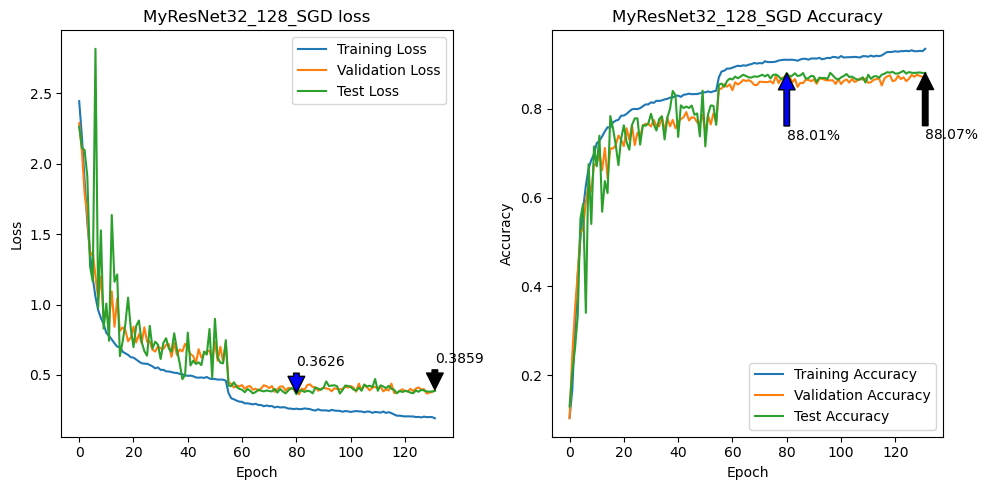

In [39]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [40]:
view.print_all()

1 epoch: train_loss=2.4456, train_acc=0.1040, test_loss=2.2637, test_acc=0.1294, valid_loss=2.2895, valid_acc=0.1028, lr=0.1000
2 epoch: train_loss=2.1928, train_acc=0.1668, test_loss=2.1129, test_acc=0.2060, valid_loss=2.0918, valid_acc=0.2456, lr=0.1000
3 epoch: train_loss=1.8797, train_acc=0.3015, test_loss=2.0979, test_acc=0.2594, valid_loss=1.7872, valid_acc=0.3480, lr=0.1000
4 epoch: train_loss=1.5824, train_acc=0.4267, test_loss=1.9098, test_acc=0.3325, valid_loss=1.6347, valid_acc=0.4280, lr=0.1000
5 epoch: train_loss=1.3653, train_acc=0.5067, test_loss=1.2723, test_acc=0.5518, valid_loss=1.3452, valid_acc=0.5208, lr=0.1000
6 epoch: train_loss=1.1885, train_acc=0.5741, test_loss=1.1632, test_acc=0.5857, valid_loss=1.3742, valid_acc=0.5300, lr=0.1000
7 epoch: train_loss=1.0547, train_acc=0.6272, test_loss=2.8175, test_acc=0.3402, valid_loss=1.2010, valid_acc=0.5904, lr=0.1000
8 epoch: train_loss=0.9595, train_acc=0.6651, test_loss=0.9785, test_acc=0.6750, valid_loss=1.0406, vali